# fineRADstructure Analysis

## File conversion
The fineRADstructure input file has to be created using `populations` from the STACKS software
```bash
populations -V bft.kinless.vcf.gz --popmap bft.popmap --radpainter --out-path .
```
The converstion process removed some loci. There are 1618 loci remaining in `bft.kinless.radpainter`

## Run RADpainter
RADpainter was run with standard parameters
```bash
RADpainter paint bft.kinless.radpainter
```

## Run finestructure
```bash
finestructure -x 100000 -y 100000 -z 1000 bft.kinless_chunks.out bft.kinless_chunks.mcmc.xml
```

## Tree building
```bash
finestructure -m T -x 10000 bft.kinless_chunks.out bft.kinless_chunks.mcmc.xml bft.kinless_chunks.mcmcTree.xml
```

## Plot results
The remainder of the code below is adapted from the [fineRADstructure repository](https://raw.githubusercontent.com/millanek/fineRADstructure/master/fineRADstructurePlot.R)

In [2]:
source("FinestructureLibrary.R", chdir = TRUE)

In [3]:
## A simple R example for plotting fineRADstructure output
## Author: Milan Malinsky (millanek@gmail.com), adapted from a Finestructure R Example by Daniel Lawson (dan.lawson@bristol.ac.uk) and using his library of R functions
## Date: 04/04/2016
chunkfile<-"bft.kinless_chunks.out" ## RADpainter output file
mcmcfile<-"bft.kinless_chunks.mcmc.xml" ## finestructure mcmc file
treefile<-"bft.kinless_chunks.mcmcTree.xml" ## finestructure tree file
maxIndv <- 10000
maxPop<-10000

Setup colours


In [4]:
some.colors<-MakeColorYRP()
# as above, but with a dark grey final for capped values
some.colorsEnd<-MakeColorYRP(final=c(0.2,0.2,0.2)) 
some.colorsEnd <- rev(heat.colors(30))

Read in the files

In [5]:
# read in the pairwise coincidence 
dataraw<-as.matrix(read.table(chunkfile,row.names=1,header=T,skip=1))
# read into xml format
mcmcxml<-xmlTreeParse(mcmcfile)
# convert this into a data frame
mcmcdata<-as.data.frame.myres(mcmcxml)
# read the tree as xml format
treexml<-xmlTreeParse(treefile)
# extract the tree into ape's phylo format
ttree<-extractTree(treexml)

In [6]:
# Reduce the amount of significant digits printed in the posteror assignment probabilities (numbers shown in the tree):
ttree$node.label[ttree$node.label!=""] <-format(as.numeric(ttree$node.label[ttree$node.label!=""]),digits=2)
# convert to dendrogram format
tdend<-myapetodend(ttree,factor=1)

#### Modifying MAP state

In [7]:
# map state as a finestructure clustering
mapstate<-extractValue(treexml,"Pop")

# map state as a list of individuals in populations
mapstatelist<-popAsList(mapstate)

# population names in a reversible/lossless format
popnames<-lapply(mapstatelist,NameSummary)
## NOTE: if your population labels don't correspond to the format we used (NAME<number>) YOU MAY HAVE TROUBLE HERE. YOU MAY NEED TO RENAME THEM INTO THIS FORM AND DEFINE YOUR POPULATION NAMES IN popnamesplot BELOW
# a nicer summary of the populations
popnamesplot<-lapply(mapstatelist,NameMoreSummary)
popnamesplot <- lapply(popnamesplot, function(x){gsub("[0-9]+", "", x)})
names(popnames)<-popnamesplot
names(popnamesplot)<-popnamesplot
# use NameSummary to make popdend
popdend<-makemydend(tdend,mapstatelist)
# needed for obscure dendrogram reasons
popdend<-fixMidpointMembers(popdend)
# use NameMoreSummary to make popdend
popdendclear<-makemydend(tdend,mapstatelist,"NameMoreSummary")
# needed for obscure dendrogram reasons
popdendclear<-fixMidpointMembers(popdendclear)

### Dendrogram

png 
  2

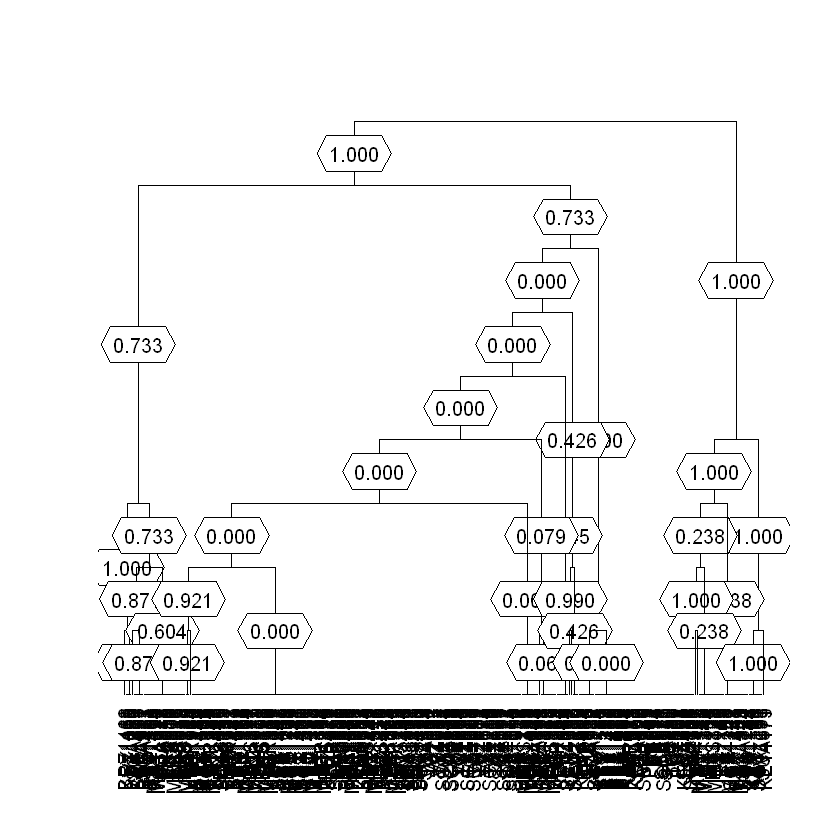

In [8]:
plot(tdend, axes = F)
pdf(file="SimpleFullDendrogram.pdf",height=6,width=35)
par(mar = c(4, 0, 0.5, 0))
plot(tdend, cex = 0.05, axes = F)
dev.off()

### Population Tree

png 
  2

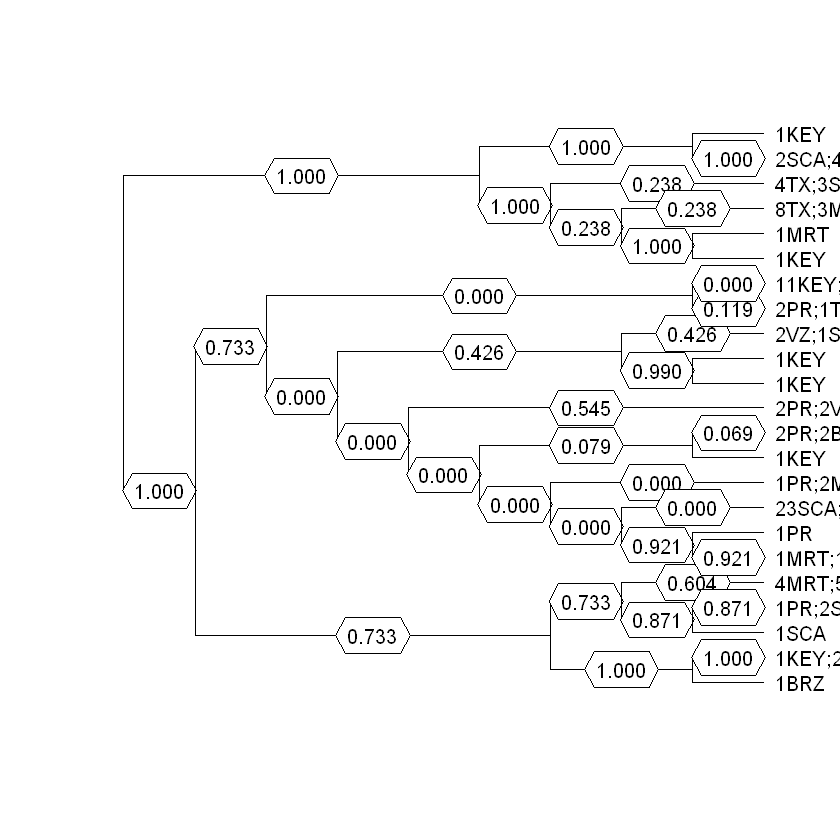

In [10]:
plot(popdendclear, axes = F, cex = 0.4, horiz = T)
pdf(file="PopulationDendrogram.pdf",height=6,width=20)
par(mar = c(0, 0, 0, 20))
plot(popdendclear, axes = F, cex = 0.4, horiz = T)
dev.off()

### Coancestry Matrix

In [11]:
# the order according to the tree
fullorder<-labels(tdend)
# reorder the data matrix
datamatrix<-dataraw[fullorder,fullorder]
tmpmat<-datamatrix 
# cap the heatmap
tmpmat[tmpmat>maxIndv]<-maxIndv

The plot

In [12]:
pdf(file="SimpleCoancestry.pdf",height=25,width=25)
plotFinestructure(tmpmat,dimnames(tmpmat)[[1]],dend=tdend,cols=some.colorsEnd,cex.axis=1.1,edgePar=list(p.lwd=0,t.srt=90,t.off=-0.1,t.cex=1.2))
dev.off()

png 
  2

### Populations and Coancestry Averages


In [13]:
popmeanmatrix<-getPopMeanMatrix(datamatrix,mapstatelist)
tmpmat<-popmeanmatrix
# cap the heatmap
tmpmat[tmpmat>maxPop]<-maxPop

The plot

In [14]:
pdf(file="PopAveragedCoancestry.pdf",height=20,width=20)
plotFinestructure(tmpmat,dimnames(tmpmat)[[1]],dend=tdend,cols=some.colorsEnd,cex.axis=1.1,edgePar=list(p.lwd=0,t.srt=90,t.off=-0.1,t.cex=1.2))
dev.off()

png 
  2